In [ ]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout
from keras.layers import Conv2D, BatchNormalization, GlobalMaxPool2D
from keras import Sequential

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf


from kornmo.sentinel.storage import SentinelDataset
from kornmo.mask.mask_dataset import MaskDataset
from kornmo.mask.utils import apply_mask_to_image_series


data_path = '../../../kornmo-data-files/raw-data/crop-classification-data/'
IMG_SIZE = 16
NUM_IMGS = 30
NUM_INDICES = 10
runtime_name = "all-indices-0-30-five-types-no-mask-optimized"


In [ ]:

print("Reading data")
data = gpd.read_file(f"{data_path}/training_data.gpkg")
data['orgnr'] = data['orgnr'].astype(int)
data['year'] = data['year'].astype(int)

print("Reading masks")
masks = MaskDataset(f"{data_path}/small_vegetation_indices_masks_train.h5")

print("Reading satellite images")
satellite_imgs = SentinelDataset(f"{data_path}/small_vegetation_indices_images_train.h5")

print(f"Loaded {len(masks.labels)} masks")
print(f"Loaded {len(satellite_imgs.labels) * NUM_IMGS} images")



data = data.loc[data['planted'] != 'erter']
data = data.loc[data['planted'] != 'oljefro']
# data = data.loc[data['planted'] != 'rughvete']
# data = data.loc[data['planted'] != 'rug']

data.drop(data[data['area'] < 1500].index, inplace = True)



labels = list(set(data['planted']))
n_classes = len(labels)

print(pd.Series(list(data['planted'])).value_counts())

def add_labels(orgnr, year, data_arg):
    orgnr = int(orgnr[:9])
    year = int(year)

    if orgnr in data['orgnr'].unique() and year in data.loc[data['orgnr'] == orgnr]['year'].unique():
        label = data.loc[data['orgnr'] == orgnr].loc[data['year'] == year]['planted'].iloc[0]
        index = labels.index(label)
        arr = [0 for _ in range(0, len(labels))]
        arr[index] = 1
        return {'class': arr}




train, val = satellite_imgs.to_iterator().split(rand_seed='corn')
train = train.with_data(add_labels, show_progress=True)
val = val.with_data(add_labels, show_progress=True)

masks_it = masks.get_iterator()
mask_dict = {}

for orgnr, year, mask in masks_it:
    mask_dict[f'{orgnr}/{year}'] = mask

print(f"train samples: {len(train)}")
print(f"val samples: {len(val)}")


Reading data
Reading satellite images
Loaded 860790 images
bygg        76231
havre       20512
hvete       18102
rug           816
rughvete      517
dtype: int64


100%|██████████| 17216/17216 [02:30<00:00, 114.28it/s]

train samples: 68569
val samples: 17153


In [ ]:

def train_generator():
    for orgnr, year, imgs, label in train:
        imgs = apply_mask_to_image_series(mask_dict[f'{orgnr}/{year}'], imgs[5:20], image_size=IMG_SIZE)
        # imgs = apply_mask_to_image_series(mask_dict[f'{orgnr}/{year}'], imgs[9:15, :, :, [1, 6, 7, 8]], image_size=IMG_SIZE)
        yield imgs[5:20], label['class']

def val_generator():
    for orgnr, year, imgs, label in val:
        imgs = apply_mask_to_image_series(mask_dict[f'{orgnr}/{year}'], imgs[5:20], image_size=IMG_SIZE)
        # imgs = apply_mask_to_image_series(mask_dict[f'{orgnr}/{year}'], imgs[9:15, :, :, [1, 6, 7, 8]], image_size=IMG_SIZE)
        yield imgs[5:20], label['class']


train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    output_types=(tf.dtypes.float64, tf.dtypes.int64),
    output_shapes=((NUM_IMGS, IMG_SIZE, IMG_SIZE, NUM_INDICES), n_classes)
)

val_dataset = tf.data.Dataset.from_generator(
    val_generator,
    output_types=(tf.dtypes.float64, tf.dtypes.int64),
    output_shapes=((NUM_IMGS, IMG_SIZE, IMG_SIZE, NUM_INDICES), n_classes)
)



In [ ]:

def build_convnet(shape=(IMG_SIZE, IMG_SIZE, NUM_INDICES)):
    momentum = 0.9
    model = Sequential()
    model.add(Conv2D(16, (3,3), input_shape=shape, padding='same', activation='relu'))
    model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))

    # model.add(MaxPool2D())

    # model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    # model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    # model.add(BatchNormalization(momentum=momentum))

    model.add(GlobalMaxPool2D())
    return model



def action_model(shape=(NUM_IMGS, IMG_SIZE, IMG_SIZE, NUM_INDICES,), n_classes=n_classes):
    convnet = build_convnet(shape[1:])

    model = Sequential()

    model.add(TimeDistributed(convnet, input_shape=shape))
    model.add(GRU(12))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    # model.add(Dense(32, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    return model


In [ ]:

model = action_model(shape=(NUM_IMGS, IMG_SIZE, IMG_SIZE, NUM_INDICES,))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

cnn_history = model.fit(
        train_dataset.take(10000).batch(32).prefetch(4),
        validation_data=val_dataset.batch(32).prefetch(4),
        epochs=100,
        verbose=1,
)


fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(model.history.history["acc"])
ax.plot(model.history.history["loss"])

ax.plot(model.history.history["val_" + "acc"])
ax.plot(model.history.history["val_" + "loss"])

ax.set_title("Classification Accuracy and Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Value")
ax.legend(["train_acc", "train_loss", "val_acc", "val_loss"])

plt.show()




In [ ]:
acc = model.history.history["acc"]
loss = model.history.history["loss"]

val_acc = model.history.history["val_" + "acc"]
val_loss = model.history.history["val_" + "loss"]

print(acc)
print(loss)
print(val_acc)
print(val_loss)

[0.6115000247955322, 0.6248000264167786, 0.6248000264167786, 0.6248000264167786, 0.6248000264167786, 0.6248000264167786, 0.6248000264167786, 0.6248000264167786, 0.6248000264167786, 0.6248000264167786, 0.6248000264167786, 0.6248000264167786, 0.6248000264167786, 0.6248000264167786, 0.6248999834060669, 0.6243000030517578, 0.625, 0.6248999834060669, 0.6256999969482422, 0.6258999705314636, 0.6259999871253967, 0.6263999938964844, 0.6261000037193298, 0.6269000172615051, 0.6298999786376953, 0.628600001335144, 0.6291000247001648, 0.6330999732017517, 0.6342999935150146, 0.6309000253677368, 0.6376000046730042, 0.6403999924659729, 0.6391000151634216, 0.6406999826431274, 0.6444000005722046, 0.6459000110626221, 0.6450999975204468, 0.6477000117301941, 0.6486999988555908, 0.6513000130653381]
[1.0103317499160767, 0.9583053588867188, 0.9489973783493042, 0.9466026425361633, 0.9470601677894592, 0.9427862167358398, 0.9416428804397583, 0.9372899532318115, 0.9384923577308655, 0.9341193437576294, 0.9327442646

In [ ]:
cnn_history2 = model.fit(
        train_dataset.take(10000).batch(32).prefetch(4),
        validation_data=val_dataset.batch(32).prefetch(4),
        epochs=100,
        verbose=1,
)

Epoch 1/100
313/313 [==============================] - 343s 1s/step - loss: 0.8375 - acc: 0.6540 - val_loss: 0.9840 - val_acc: 0.6284
Epoch 2/100
313/313 [==============================] - 314s 1s/step - loss: 0.8334 - acc: 0.6547 - val_loss: 1.0051 - val_acc: 0.6247
Epoch 3/100
313/313 [==============================] - 322s 1s/step - loss: 0.8326 - acc: 0.6572 - val_loss: 0.9981 - val_acc: 0.6278
Epoch 4/100
313/313 [==============================] - 311s 993ms/step - loss: 0.8189 - acc: 0.6630 - val_loss: 1.0032 - val_acc: 0.6210
Epoch 5/100
313/313 [==============================] - 314s 1s/step - loss: 0.8206 - acc: 0.6621 - val_loss: 1.0197 - val_acc: 0.6114
Epoch 6/100
313/313 [==============================] - 302s 964ms/step - loss: 0.8227 - acc: 0.6562 - val_loss: 0.9918 - val_acc: 0.6244
Epoch 7/100
313/313 [==============================] - 309s 988ms/step - loss: 0.8141 - acc: 0.6626 - val_loss: 0.9958 - val_acc: 0.6262
Epoch 8/100
313/313 [==============================] 

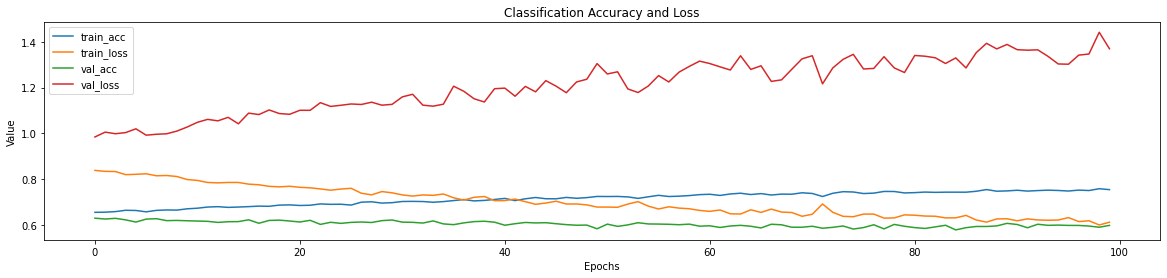

In [ ]:
_, ax = plt.subplots(figsize=(20, 4))

ax.plot(model.history.history["acc"])
ax.plot(model.history.history["loss"])

ax.plot(model.history.history["val_" + "acc"])
ax.plot(model.history.history["val_" + "loss"])

ax.set_title("Classification Accuracy and Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Value")
ax.legend(["train_acc", "train_loss", "val_acc", "val_loss"])

plt.show()